In [1]:
## ---------- ##
# Environment #
## ---------- ##

import os
cwd = os.getcwd()

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import tensorflow as tf
import numpy as np

# SEED experiments are to be reproducible. 
SEED = 1234
tf.random.set_seed(SEED)  

# Access to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Image Segmentation ACRE
## Build dataset

In [2]:
# ------------------ #
# ImageDataGenerator
# ------------------ #
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_data_gen = ImageDataGenerator()
mask_data_gen = ImageDataGenerator()

In [3]:
from PIL import Image

class CustomDataset(tf.keras.utils.Sequence):

  """
    CustomDataset inheriting from tf.keras.utils.Sequence.

    3 main methods:
      - __init__: save dataset params like directory, filenames..
      - __len__: return the total number of samples in the dataset
      - __getitem__: return a sample from the dataset

    Note: 
      - the custom dataset return a single sample from the dataset. Then, we use 
        a tf.data.Dataset object to group samples into batches.
      - in this case we have a different structure of the dataset in memory. 
        We have all the images in the same folder and the training and validation splits
        are defined in text files.

  """

  def __init__(self, dataset_dir, which_subset, img_generator=None, mask_generator=None, 
               preprocessing_function=None,validation_part=0.2,out_shape=[256,256],projects=['Weedelec','Pead','Roseau','Bipbip'],plants=['Haricot','Mais']):
    
    # ---------- #
    # Attributs  #
    # ---------- #

    self.png_or_jpg = []
    self.subset_filenames = []
    self.subset_direc = []

    self.which_subset = which_subset
    self.dataset_dir = dataset_dir
    self.img_generator = img_generator
    self.mask_generator = mask_generator
    self.preprocessing_function = preprocessing_function
    self.out_shape = out_shape
    
    for project in projects :
      for plant in plants :
        path = os.path.join(dataset_dir,project,plant)
        list_ = os.listdir(os.path.join(path,'Images')) 
        number_files = len(list_)
        training_num_max = int(number_files - int(number_files *  (1 - validation_part)))
        
        # ----- Training set  ----- #

        if which_subset == 'training':
          number_max = training_num_max
          for ii in range(0,number_max):
            self.subset_filenames.append(os.path.splitext(list_[ii])[0])
            self.subset_direc.append(path)

            if project!='Roseau': # Roseau has images and masks as png.
              self.png_or_jpg.append(1)
            else:
              self.png_or_jpg.append(0)

        # ----- Validation set  ----- #
              
        elif which_subset == 'validation':
          number_max = number_files - training_num_max
          for ii in range(number_files - 1, number_files - number_max, -1):
            self.subset_filenames.append(os.path.splitext(list_[ii])[0])
            self.subset_direc.append(path)
            if project!='Roseau':
              self.png_or_jpg.append(1)
            else:
              self.png_or_jpg.append(0)
            

  def __len__(self):
    return len(self.subset_filenames)

  
  def __getitem__(self, index):
    
    #Read files (image and target)
    curr_filename = self.subset_filenames[index]
    curr_dir = self.subset_direc[index]
    
    if self.png_or_jpg[index] != 0:
      img = Image.open(os.path.join(curr_dir, 'Images', curr_filename + '.jpg'))
    else:
      img = Image.open(os.path.join(curr_dir, 'Images', curr_filename + '.png'))
    
    mask = Image.open(os.path.join(curr_dir, 'Masks', curr_filename + '.png'))

    # Resize 
    img = img.resize(self.out_shape)
    mask = mask.resize(self.out_shape, resample=Image.NEAREST)

    mask_arr = np.array(mask)
    new_mask_arr = np.zeros(mask_arr.shape[:2], dtype=mask_arr.dtype)

    # Use RGB dictionary in 'RGBtoTarget.txt' to convert RGB to target
    new_mask_arr[np.where(np.all(mask_arr == [216, 124, 18], axis=-1))] = 0
    new_mask_arr[np.where(np.all(mask_arr == [255, 255, 255], axis=-1))] = 1
    new_mask_arr[np.where(np.all(mask_arr == [216, 67, 82], axis=-1))] = 2
    
    img_arr = np.array(img)
    mask_arr = new_mask_arr
    mask_arr = np.expand_dims(mask_arr, -1)

    if self.which_subset == 'training':
      if self.img_generator is not None and self.mask_generator is not None:
        
        # Perform data augmentation
        
        img_t = self.img_generator.get_random_transform(img_arr.shape, seed=SEED)
        mask_t = self.mask_generator.get_random_transform(mask_arr.shape, seed=SEED)
        img_arr = self.img_generator.apply_transform(img_arr, img_t)
        
        out_mask = np.zeros_like(mask_arr)
        for c in np.unique(mask_arr):
          if c > 0:
            curr_class_arr = np.float32(mask_arr == c)
            curr_class_arr = self.mask_generator.apply_transform(curr_class_arr, mask_t)
            # from [0, 1] to {0, 1}
            curr_class_arr = np.uint8(curr_class_arr)
            # recover original class
            curr_class_arr = curr_class_arr * c 
            out_mask += curr_class_arr
    else:
      out_mask = mask_arr
    
    img_arr=1./255*img_arr
    if self.preprocessing_function is not None:
        img_arr = self.preprocessing_function(img_arr)

    return img_arr, np.float32(out_mask)

In [4]:
path = '/content/drive/MyDrive/Keras_Tutorial_4/Development_Dataset/Training/'
val_part = 0.2

dataset = CustomDataset(path, 'training', 
                        img_generator=img_data_gen, 
                        mask_generator=mask_data_gen,
                        out_shape=[512,512],
                        preprocessing_function=None,
                        validation_part=val_part,
                        projects=['Weedelec','Pead','Roseau','Bipbip'],
                        plants=['Mais','Haricot'])
dataset_valid = CustomDataset(path, 'validation', 
                            preprocessing_function=None,
                            out_shape=[512,512],
                            validation_part=val_part,
                            projects=['Weedelec','Pead','Roseau','Bipbip'],
                            plants=['Mais','Haricot'])

In [5]:
img_h = 512
img_w = 512
bs = 10

train_dataset = tf.data.Dataset.from_generator(lambda: dataset,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))
train_dataset = train_dataset.batch(bs)

train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: dataset_valid,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w,1]))
valid_dataset = valid_dataset.batch(bs)

valid_dataset = valid_dataset.repeat()

In [6]:
# ---------------------------- #
# Test of the dataset creation
# ---------------------------- #

import time
from matplotlib import cm
import matplotlib.pyplot as plt

%matplotlib inline

# Assign a color to each class
evenly_spaced_interval = np.linspace(0, 1, 2)
colors = [cm.rainbow(x) for x in evenly_spaced_interval]

iterator = iter(train_dataset)

[0. 1. 2.]


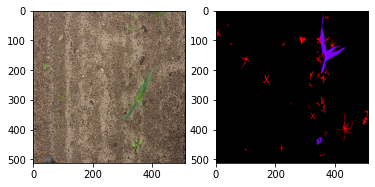

In [7]:
fig, ax = plt.subplots(1, 2)

augmented_img, target = next(iterator)
augmented_img = augmented_img[1]   # First element
augmented_img = 255*augmented_img  # denormalize

target = np.array(target[0, ..., 0])   # First element (squeezing channel dimension)

print(np.unique(target))

target_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = [0, 0, 0]
for i in range(1, 3):
  target_img[np.where(target == i)] = np.array(colors[i-1])[:3] * 255

ax[0].imshow(np.uint8(augmented_img))
ax[1].imshow(np.uint8(target_img))

plt.show()

## Network for image classifaction
### Encoder -Decoder

In [8]:
def create_model(num_classes,depth,start_f):

    model = tf.keras.Sequential()
    
    # Encoder
    # -------
    inputs = tf.keras.Input(shape=(img_h, img_w, 3))
    x=inputs
    for i in range(0,depth):
      x = tf.keras.layers.Conv2D(filters=start_f, 
                      kernel_size=(3, 3),
                      strides = (1,1),
                      padding = 'same')(x)
      x = tf.keras.layers.BatchNormalization()(x)
      x = tf.keras.layers.Activation('relu')(x)
      x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
      start_f=2*start_f
    
    model.add(tf.keras.Model(inputs=inputs, outputs=x))
    
    # Bottleneck
    # -------   
    model.add(tf.keras.layers.Conv2D(filters=start_f, kernel_size=(3, 3), strides=(1, 1), padding='same'))
    model.add(tf.keras.layers.ReLU())
    
    start_f = start_f // 2

    # Decoder
    # -------
    for i in range(0,depth):
        model.add(tf.keras.layers.UpSampling2D(2, interpolation='bilinear'))
        model.add(tf.keras.layers.Conv2D(filters=start_f,
                                         kernel_size=(3, 3),
                                         strides=(1, 1),
                                         padding='same'))
        model.add(tf.keras.layers.ReLU())
        start_f = start_f // 2

    # Prediction Layer
    # ----------------
    model.add(tf.keras.layers.Dropout(0.4,seed=SEED))
    model.add(tf.keras.layers.Conv2D(filters=num_classes,
                                     kernel_size=(1, 1),
                                     strides=(1, 1),
                                     padding='same',
                                     activation='softmax'))
    tf.keras.backend.clear_session()
    
    return model

In [9]:
model = create_model(num_classes=3,start_f=32,depth=5)

# Model summary
model.summary()

# Weights summary
# model.weights

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 16, 16, 512)       1572544   
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 1024)      4719616   
_________________________________________________________________
re_lu (ReLU)                 (None, 16, 16, 1024)      0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 32, 32, 1024)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 512)       4719104   
_________________________________________________________________
re_lu_1 (ReLU)               (None, 32, 32, 512)       0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 64, 64, 512)       0

## Prepare the model for training

In [10]:
# ---------------------------- #
#    Optimization parameters   #
# ---------------------------- #

# Loss
loss = tf.keras.losses.SparseCategoricalCrossentropy() 
# Learning rate
lr = 1e-5
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)


# Metric for image segmentation 

def meanIoU(y_true, y_pred):
    # get predicted class from softmax
    y_pred = tf.expand_dims(tf.argmax(y_pred, -1), -1)

    per_class_iou = []

    for i in range(1,3): # exclude the background class 0
    
      # Get prediction and target related to only a single class (i)
      class_pred = tf.cast(tf.where(y_pred == i, 1, 0), tf.float32)
      class_true = tf.cast(tf.where(y_true == i, 1, 0), tf.float32)
      intersection = tf.reduce_sum(class_true * class_pred)
      union = tf.reduce_sum(class_true) + tf.reduce_sum(class_pred) - intersection
    
      iou = (intersection + 1e-7) / (union + 1e-7)
      per_class_iou.append(iou)

    return tf.reduce_mean(per_class_iou)

# ------------------- #
#  Validation metrics #
# ------------------- #

metrics = [ meanIoU,'accuracy']

# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

## Training with callbacks

In [11]:
callbacks = []

early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    callbacks.append(es_callback)


history=model.fit(x=train_dataset,
          epochs=15,  
          steps_per_epoch=250,
          validation_data=valid_dataset,
          validation_steps=30, 
          callbacks=callbacks)

Epoch 1/15
250/250 [==============================] - 1348s 5s/step - loss: 0.3953 - meanIoU: 0.0227 - accuracy: 0.8775 - val_loss: 0.3630 - val_meanIoU: 2.3066e-12 - val_accuracy: 0.9286
Epoch 2/15
250/250 [==============================] - 1058s 4s/step - loss: 0.1877 - meanIoU: 0.1459 - accuracy: 0.9381 - val_loss: 0.2648 - val_meanIoU: 0.0562 - val_accuracy: 0.9331
Epoch 3/15
250/250 [==============================] - 1029s 4s/step - loss: 0.1653 - meanIoU: 0.1686 - accuracy: 0.9426 - val_loss: 0.2588 - val_meanIoU: 0.0543 - val_accuracy: 0.9329
Epoch 4/15
250/250 [==============================] - 1025s 4s/step - loss: 0.1474 - meanIoU: 0.1916 - accuracy: 0.9472 - val_loss: 0.2138 - val_meanIoU: 0.1591 - val_accuracy: 0.9344
Epoch 5/15
250/250 [==============================] - 1026s 4s/step - loss: 0.1393 - meanIoU: 0.2414 - accuracy: 0.9489 - val_loss: 0.2551 - val_meanIoU: 0.1105 - val_accuracy: 0.9384
Epoch 6/15
250/250 [==============================] - 996s 4s/step - loss: 0

# Test model
### Results on validation 
### Plot accuracy, loss, meanIoU
### Submission

In [13]:
#------------------------------
#       MODEL SAVING
#------------------------------

out = '/content/drive/My Drive/'



model_name = 'Basic'

model.save(out + '/' + model_name +  '.h5')


## Compute prediction

In [ ]:
import time
import matplotlib.pyplot as plt

from PIL import Image

%matplotlib inline

iterator = iter(valid_dataset)

(1, 256, 256, 3)

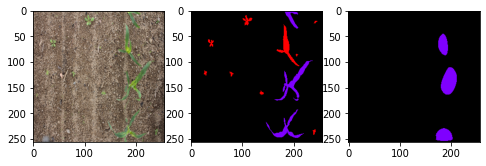

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(8, 8))
fig.show()
image, target = next(iterator)

image = image[0]
target = target[0, ..., 0]


out_sigmoid = model.predict(x=tf.expand_dims(image, 0))

# Get predicted class as the index corresponding to the maximum value in the vector probability
# predicted_class = tf.cast(out_sigmoid > score_th, tf.int32)
# predicted_class = predicted_class[0, ..., 0]
predicted_class = tf.argmax(out_sigmoid, -1)

out_sigmoid.shape

predicted_class = predicted_class[0, ...]

# Assign colors (just for visualization)
target_img = np.zeros([target.shape[0], target.shape[1], 3])
prediction_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = [0, 0, 0]
for i in range(1, 3):
  target_img[np.where(target == i)] = np.array(colors[i-1])[:3] * 255

prediction_img[np.where(predicted_class == 0)] = [0, 0, 0]
for i in range(1, 3):
  prediction_img[np.where(predicted_class == i)] = np.array(colors[i-1])[:3] * 255

ax[0].imshow(np.uint8(255*image))
ax[1].imshow(np.uint8(target_img))
ax[2].imshow(np.uint8(prediction_img))

fig.canvas.draw()
time.sleep(1)

dict_keys(['loss', 'meanIoU', 'accuracy', 'val_loss', 'val_meanIoU', 'val_accuracy'])


Text(0.5, 1.0, 'model accuracy')

Text(0, 0.5, 'accuracy')

Text(0.5, 0, 'epoch')

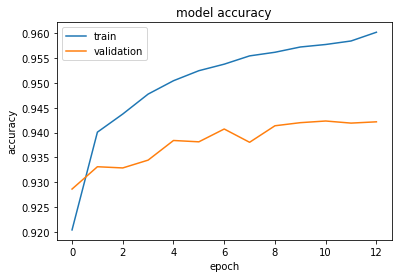

Text(0.5, 1.0, 'model loss')

Text(0, 0.5, 'loss')

Text(0.5, 0, 'epoch')

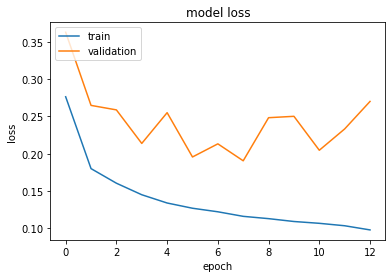

Text(0.5, 1.0, 'model meanIoU')

Text(0, 0.5, 'meanIoU')

Text(0.5, 0, 'epoch')

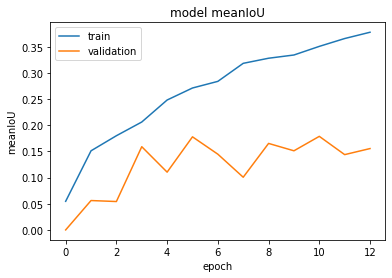

In [12]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for meanIoU
plt.plot(history.history['meanIoU'])
plt.plot(history.history['val_meanIoU'])
plt.title('model meanIoU')
plt.ylabel('meanIoU')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
from PIL import Image

class CustomDataSol(tf.keras.utils.Sequence):

  def __init__(self, dataset_dir, img_generator=None,
               preprocessing_function=None, out_shape=[512,512],projects=['Weedelec','Pead','Roseau','Bipbip'],plants=['Haricot','Mais']):

    self.subset_filenames = []
    self.subset_direc = []
    self.name_project = []
    self.name_plant = []
    self.dataset_dir = dataset_dir
    self.img_generator = img_generator
    self.preprocessing_function = preprocessing_function
    self.out_shape = out_shape

    for project in projects :
      for plant in plants :
        path=os.path.join(dataset_dir,project,plant)
        list = os.listdir(os.path.join(path,'Images'))
        number_files = len(list)
        for ii in range(0,number_files):
            self.subset_filenames.append(os.path.splitext(list[ii])[0])
            self.subset_direc.append(path)
            self.name_project.append(project)
            self.name_plant.append(plant)
    
  def __len__(self):
    return len(self.subset_filenames)

  def __getitem__(self, index):
    # Read Image
    curr_filename = self.subset_filenames[index]
    curr_dir = self.subset_direc[index]
    curr_project = self.projects[index]
    if curr_project == 'Roseau' :
      img = Image.open(os.path.join(curr_dir, 'Images', curr_filename + '.png'))
    else :
      img = Image.open(os.path.join(curr_dir, 'Images', curr_filename + '.jpg'))

    # Resize image 
    img = img.resize(self.out_shape)
    img_arr = np.array(img)
    
    if self.preprocessing_function is not None:
        img_arr = self.preprocessing_function(img_arr)

    return img_arr

################################################################################
 # Encode array (start kit)

def rle_encode(img):
    '''
    img: numpy array, 1 - foreground, 0 - background
    Returns run length as string formatted
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


################################################################################

path_test = '/content/drive/My Drive/Keras_Tutorial_4/Development_Dataset/Test_Dev/'
test_set=CustomDataSol(path_test, 
                        img_generator=img_data_gen,
                        projects=['Weedelec','Pead','Roseau','Bipbip'],
                        plants=['Mais','Haricot'])
test_dataset = tf.data.Dataset.from_generator(lambda: test_set,
                                               output_types= tf.float32,
                                               output_shapes=[img_h, img_w, 3])

test_dataset = test_dataset.batch(1)
iterator = iter(test_dataset)
test_set.__len__()
    
submission_dict = {}
SIZE=[[1536,2048],[2464,3280],[819,1228],[3456,5184]]
for index in range(0,test_set.__len__()):#
      image = next(iterator)
      if test_set.projects[index]=='Bipbip':
        size_im=SIZE[0]
      elif test_set.projects[index]=='Pead':
        size_im=SIZE[1]
      elif test_set.projects[index]=='Roseau':
        size_im=SIZE[2]
      else:
        size_im=SIZE[3]
      img_name = os.path.splitext(test_set.subset_filenames[index])[0]
      submission_dict[img_name] = {}
      mask_arr =  model.predict(image)
      mask_arr = tf.image.resize(mask_arr, size_im, method='nearest')
      #mask_arr.size
      predicted_class = tf.argmax(mask_arr, -1)
      predicted_class = predicted_class[0, ...]
      prediction_img = np.zeros([size_im[0], size_im[1]])
      #prediction_img2 = np.zeros([size_im[0], size_im[1], 3])
  
      prediction_img[np.where(predicted_class == 0)] = 0
      #prediction_img2[np.where(predicted_class == 0)] = [0, 0, 0]
      for i in range(1, 3):
        prediction_img[np.where(predicted_class == i)] = i
        #prediction_img2[np.where(predicted_class == i)] = np.array(colors[i-1])[:3] * 255
      #fig, ax = plt.subplots(1, 2, figsize=(10, 10))
      #fig.show() 
      #print(np.uint8(prediction_img2).size)   
      #ax[0].imshow(np.uint8(prediction_img2))
      #ax[1].imshow(np.uint8(image[0]))
      #fig.canvas.draw()
      #time.sleep(1)

      submission_dict[img_name]['shape'] = size_im
      submission_dict[img_name]['team'] = test_set.projects[index]
      submission_dict[img_name]['crop'] = test_set.plants[index]
      submission_dict[img_name]['segmentation'] = {}
    
    # crop
      rle_encoded_crop = rle_encode(prediction_img == 1)
    # weed
      rle_encoded_weed = rle_encode(prediction_img == 2)

      submission_dict[img_name]['segmentation']['crop'] = rle_encoded_crop
      submission_dict[img_name]['segmentation']['weed'] = rle_encoded_weed

import json
with open('/content/drive/My Drive/submission42.json', 'w') as file:
      json.dump(submission_dict, file)

120